# Clustering on generated data

In [1]:
import os
import sys

sys.path.append("../")

In [16]:
import numpy as np
from sklearn.datasets import make_blobs, make_moons, make_circles
import seaborn as sns
from matplotlib import pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from src.ml.sinkhorn import SinkhornValue, pot_sinkhorn

In [17]:
sns.set(style="whitegrid")

## Dataset generation

In [18]:
n_features = 512
n_clusters = 10
batch_size = 256

In [19]:
class ToyDataset(Dataset):
    def __init__(self, n_features, n_clusters):
        self.n_features = n_features
        self.n_clusters = n_clusters
    
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y_true[idx]
    
    def plot(self):
        fig, ax = plt.subplots(
            nrows=1,
            ncols=1,
            figsize=(5, 5)
        )

        sns.scatterplot(  # plot first 2 components
            x=self.X[:, 0],
            y=self.X[:, 1],
            hue=map(str, self.y_true),
            ax=ax,
            legend=False
        )

        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")
        ax.set_title("Clusters visualization")

        return fig


class BlobsDataset(ToyDataset):
    """
    https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html
    """
    def __init__(self, n_features, n_clusters):
        super().__init__(n_features, n_clusters)
        
        X, y_true = make_blobs(
            n_samples=2000,
            n_features=n_features,
            centers=n_clusters,
            cluster_std=.8,
            random_state=0
        )
        
        self.X = torch.FloatTensor(X)
        self.y_true = torch.LongTensor(y_true)
        
class MoonsDataset(ToyDataset):
    def __init__(self):
        super().__init__(n_features=2, n_clusters=2)
        
        X, y_true = make_moons(
            n_samples=2000,
            random_state=0,
            noise=.05
        )
        
        self.X = torch.FloatTensor(X)
        self.y_true = torch.LongTensor(y_true)
        
        
class CirclesDataset(ToyDataset):
    def __init__(self):
        super().__init__(n_features=2, n_clusters=2)
        
        X, y_true = make_circles(
            n_samples=2000,
            random_state=0,
            noise=.05
        )
        
        self.X = torch.FloatTensor(X)
        self.y_true = torch.LongTensor(y_true)

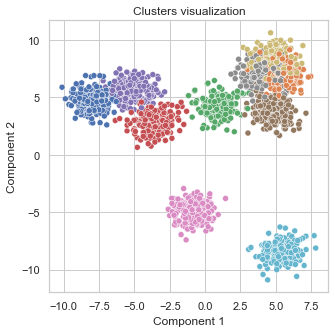

In [20]:
blobs_dataset = BlobsDataset(n_features=512, n_clusters=10)
blobs_dataset.plot();

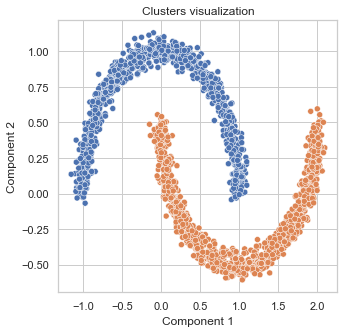

In [21]:
moons_dataset = MoonsDataset()
moons_dataset.plot();

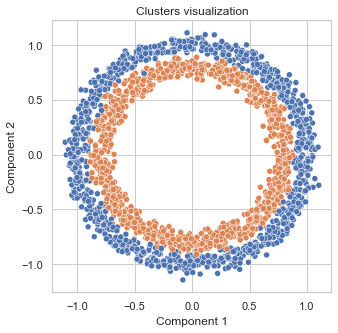

In [22]:
circles_dataset = CirclesDataset()
circles_dataset.plot();

## Model definition

In [23]:
class Model(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
        )
    
    def forward(self, inputs):
        mlp_out = self.mlp(inputs)
        softmax_out = nn.LogSoftmax(dim=1)(mlp_out)
        
        return softmax_out

In [24]:
def train_model(model, dataloader, optimizer, n_clusters):
    # init Sinkhorn loss
    SV = SinkhornValue(
        epsilon=.1,
        solver=pot_sinkhorn,
        max_n_batches_in_queue=0,
        stopThr=1e-02,
        method="sinkhorn_log",
        numItermax=100
    )

    for epoch in range(100):
        epoch_loss = 0

        for batch_ix, (inputs, y_true) in enumerate(dataloader):
            a = torch.ones(inputs.shape[0]) / inputs.shape[0]  # batch size
            b = torch.ones(n_clusters) / n_clusters            # number of clusters

            model.train()

            P = model(inputs)
            M = P - np.log(inputs.shape[0])

            # set gradients to zero
            optimizer.zero_grad()

            # compute Sinkhorn loss
            loss = -SV(M)

            # compute gradients
            loss.backward()

            # backpropagation
            optimizer.step()

            epoch_loss += loss.item()

        if epoch % 10 == 0:
            print("Epoch {0} loss: {1:.4f}".format(epoch+1, epoch_loss / (batch_ix+1)))

In [25]:
dataloader = DataLoader(
    moons_dataset,
    shuffle=True,
    batch_size=batch_size
)

model = Model(
    input_dim=dataloader.dataset.n_features,
    output_dim=7
)

optimizer = torch.optim.Adam(
    lr=0.001,
    params=model.parameters()
)

train_model(model, dataloader, optimizer, n_clusters=7)

Epoch 1 loss: 7.4717
Epoch 11 loss: 7.4651
Epoch 21 loss: 7.4651
Epoch 31 loss: 7.4651
Epoch 41 loss: 7.4651
Epoch 51 loss: 7.4651
Epoch 61 loss: 7.4651
Epoch 71 loss: 7.4651
Epoch 81 loss: 7.4652
Epoch 91 loss: 7.4651
Epoch 101 loss: 7.4651
Epoch 111 loss: 7.4651
Epoch 121 loss: 7.4651
Epoch 131 loss: 7.4651
Epoch 141 loss: 7.4651
Epoch 151 loss: 7.4651
Epoch 161 loss: 7.4651
Epoch 171 loss: 7.4651
Epoch 181 loss: 7.4651
Epoch 191 loss: 7.4651


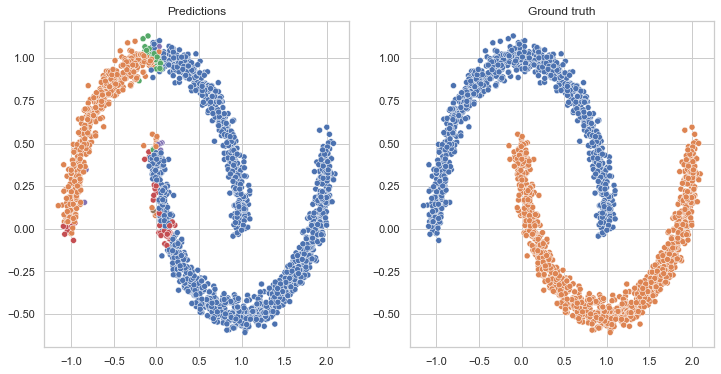

In [27]:
# predict
inputs = [item for (item, _) in dataloader.dataset]
y_true = [label for (_, label) in dataloader.dataset]

inputs = torch.stack(inputs)
y_true = torch.stack(y_true)

P = model(inputs)

# plot figure
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.scatterplot(
    x=inputs[:, 0],
    y=inputs[:, 1],
    hue=map(str, torch.argmax(P, axis=1)),
    legend=False,
    ax=axs[0]
)

sns.scatterplot(
    x=inputs[:, 0],
    y=inputs[:, 1],
    hue=map(str, y_true),
    legend=False,
    ax=axs[1]
)

axs[0].set_title("Predictions")
axs[1].set_title("Ground truth")

plt.show()

In [ ]:
# tester avec des marginales 0.5, 0.25, 0.25 (optionnel)

# vérifier si la loss décroit avec cifar pretrained
# faire tourner asano à notre sauce sur cifar10
# voir si on doit réutiliser les tricks de caron pour les minibatches